In [ ]:
# Zach Quinn 
# DSC 630 - Predictive Analytics
# Hotel_Recommendation.ipynb 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from datetime import datetime
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

warnings.simplefilter('ignore')

In [3]:
# Load data and sample 100,000 observations to obtain sample size and conserve memory. 
# Read train set.
hotel_train = pd.read_csv('train_3.csv', nrows=100000)
# Read test set.
hotel_test = pd.read_csv('test.csv', nrows=100000)
# Read destination flat file. 
hotel_destinations = pd.read_csv('destinations.csv', nrows=100000)

In [4]:
hotel_train.head(3)

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1


<AxesSubplot:xlabel='hotel_cluster', ylabel='Density'>

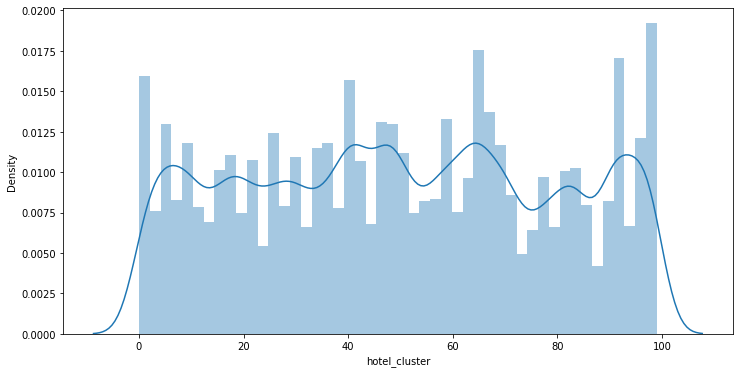

In [5]:
# Conduct univariate analysis of hotel clusters. 
plt.figure(figsize=(12, 6))
# Creates distribution plot. 
sns.distplot(hotel_train['hotel_cluster'])

In [6]:
# Fuunction for extracting year and month from check in and check out columns. 

def extract_year(x): 
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').year
        except ValueError:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').year
    else:
        return 2013 
    pass

def extract_month(x):
    if x is not None and type(x) is not float:
        try:
            return datetime.strptime(x, '%Y-%m-%d').month
        except ValueError:
            return datetime.strptime(x, '%Y-%m-%d %H:%M:%S').month
    else:
        return 1
    pass

def left_merge_dataset(left_dframe, right_dframe, merge_column):
        return pd.merge(left_dframe, right_dframe, on=merge_column, how='left')

In [7]:
# Convert columns to Pandas series for manipulation and analysis. 
hotel_train['date_time_year'] = pd.Series(hotel_train.date_time, index = hotel_train.index)
hotel_train['date_time_month'] = pd.Series(hotel_train.date_time, index = hotel_train.index)
hotel_train.date_time_year = hotel_train.date_time_year.apply(lambda x: extract_year(x))
hotel_train.date_time_month = hotel_train.date_time_month.apply(lambda x: extract_month(x))
# Delete date_time column. 
del hotel_train['date_time']

In [8]:
hotel_train['srch_ci_year'] = pd.Series(hotel_train.srch_ci, index=hotel_train.index)
hotel_train['srch_ci_month'] = pd.Series(hotel_train.srch_ci, index=hotel_train.index)
# Converting years & months to int types.
hotel_train.srch_ci_year = hotel_train.srch_ci_year.apply(lambda x: extract_year(x))
hotel_train.srch_ci_month = hotel_train.srch_ci_month.apply(lambda x: extract_month(x))
# Delete srch_ci column. 
del hotel_train['srch_ci']

In [9]:
hotel_train['srch_co_year'] = pd.Series(hotel_train.srch_co, index=hotel_train.index)
hotel_train['srch_co_month'] = pd.Series(hotel_train.srch_co, index=hotel_train.index)
# convert year & months to int
hotel_train.srch_co_year = hotel_train.srch_co_year.apply(lambda x: extract_year(x))
hotel_train.srch_co_month = hotel_train.srch_co_month.apply(lambda x: extract_month(x))
# remove the srch_co column
del hotel_train['srch_co']

In [10]:
# Tracks correlation of columns and sorts values. 
hotel_train.corr()['hotel_cluster'].sort_values()

srch_destination_type_id    -0.030064
is_booking                  -0.025380
user_location_country       -0.025170
hotel_country               -0.021170
site_name                   -0.019154
hotel_continent             -0.008441
srch_destination_id         -0.007258
user_location_city          -0.006580
channel                     -0.005956
srch_rm_cnt                 -0.005801
is_mobile                   -0.002803
srch_co_month               -0.000413
date_time_year               0.000696
cnt                          0.000914
date_time_month              0.001208
user_id                      0.001396
srch_ci_month                0.001682
posa_continent               0.002204
srch_children_cnt            0.005469
srch_adults_cnt              0.007322
user_location_region         0.008037
srch_ci_year                 0.010879
orig_destination_distance    0.011362
srch_co_year                 0.012014
hotel_market                 0.036107
is_package                   0.051955
hotel_cluste

In [11]:
# Displays new data.
hotel_train.head(3)

,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,channel,...,hotel_continent,hotel_country,hotel_market,hotel_cluster,date_time_year,date_time_month,srch_ci_year,srch_ci_month,srch_co_year,srch_co_month
0,2,3,66,348,48862,2234.2641,12,0,1,9,...,2,50,628,1,2014,8,2014,8,2014,8
1,2,3,66,348,48862,2234.2641,12,0,1,9,...,2,50,628,1,2014,8,2014,8,2014,9
2,2,3,66,348,48862,2234.2641,12,0,0,9,...,2,50,628,1,2014,8,2014,8,2014,9


<AxesSubplot:>

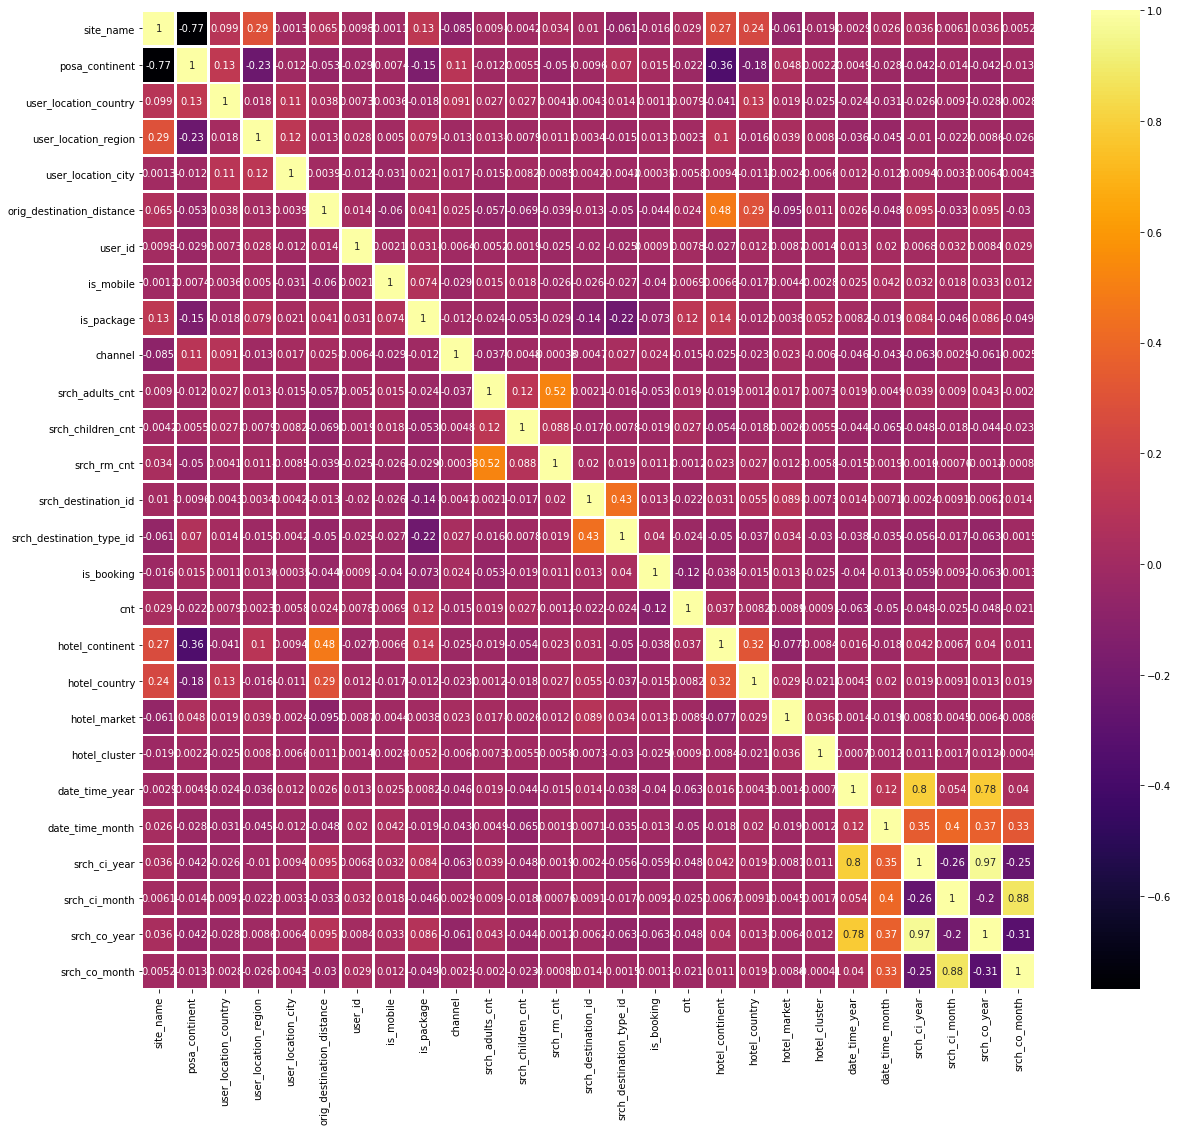

In [12]:
# Create correlation heat map using Seaborn library.
fig, ax = plt.subplots()
# Set size and dimensions. 
fig.set_size_inches(20, 18)
sns.heatmap(hotel_train.corr(), cmap='inferno', ax=ax, annot=True, linewidths=1.5)

In [13]:
# One hot encode hotel booking data. 
hotel_train_book = hotel_train.loc[hotel_train['is_booking'] == 1]

In [14]:
# Factorize columns to examine impact of hotel country and market on identifying clusters. 
hotel_factor = [hotel_train_book.groupby(['srch_destination_id','hotel_country','hotel_market','is_package','hotel_cluster'])['is_booking'].agg(['sum','count'])]
summ = pd.concat(hotel_factor).groupby(level=[0,1,2,3,4]).sum()
# Drop na values. 
summ.dropna(inplace=True)
# Display manipulated data. 
summ.head()

sum  \
srch_destination_id hotel_country hotel_market is_package hotel_cluster        
8                   50            416          0          32               1   
                                                          77               1   
11                  50            824          0          94               1   
14                  27            1434         0          20               1   
16                  50            419          0          7                1   

                                                                         count  
srch_destination_id hotel_country hotel_market is_package hotel_cluster         
8                   50            416          0          32                 1  
                                                          77                 1  
11                  50            824          0          94                 1  
14                  27            1434         0          20                 1  
16                  50            419          0          7                  1

In [15]:
summ['sum_and_cnt'] = 0.85*summ['sum'] + 0.15*summ['count']
summ = summ.groupby(level=[0,1,2,3]).apply(lambda x: x.astype(float)/x.sum())
summ.reset_index(inplace=True)
summ.head()

,srch_destination_id,hotel_country,hotel_market,is_package,hotel_cluster,sum,count,sum_and_cnt
0,8,50,416,0,32,0.5,0.5,0.5
1,8,50,416,0,77,0.5,0.5,0.5
2,11,50,824,0,94,1.0,1.0,1.0
3,14,27,1434,0,20,1.0,1.0,1.0
4,16,50,419,0,7,1.0,1.0,1.0


In [16]:
# Create pivot table with destination id, hotel country and hotel market. 
summ_pivot = summ.pivot_table(index=['srch_destination_id','hotel_country','hotel_market','is_package'], columns='hotel_cluster', values='sum_and_cnt').reset_index()
summ_pivot.head()

hotel_cluster,srch_destination_id,hotel_country,hotel_market,is_package,0,1,2,3,4,5,...,90,91,92,93,94,95,96,97,98,99
0,8,50,416,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11,50,824,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,14,27,1434,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16,50,419,0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21,77,1454,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
# Read in destination file. 
hotel_destination = pd.read_csv('destinations.csv', nrows=100000)
hotel_destination.head(5)

,srch_destination_id,d1,d2,d3,d4,d5,d6,d7,d8,d9,...,d140,d141,d142,d143,d144,d145,d146,d147,d148,d149
0,0,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-1.897627,-2.198657,-2.198657,-1.897627,...,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657,-2.198657
1,1,-2.181690,-2.181690,-2.181690,-2.082564,-2.181690,-2.165028,-2.181690,-2.181690,-2.031597,...,-2.165028,-2.181690,-2.165028,-2.181690,-2.181690,-2.165028,-2.181690,-2.181690,-2.181690,-2.181690
2,2,-2.183490,-2.224164,-2.224164,-2.189562,-2.105819,-2.075407,-2.224164,-2.118483,-2.140393,...,-2.224164,-2.224164,-2.196379,-2.224164,-2.192009,-2.224164,-2.224164,-2.224164,-2.224164,-2.057548
3,3,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.115485,-2.177409,-2.177409,-2.177409,...,-2.161081,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409,-2.177409
4,4,-2.189562,-2.187783,-2.194008,-2.171153,-2.152303,-2.056618,-2.194008,-2.194008,-2.145911,...,-2.187356,-2.194008,-2.191779,-2.194008,-2.194008,-2.185161,-2.194008,-2.194008,-2.194008,-2.188037


In [18]:
# Merge hotel train set with destination file. 
hotel_train_book = pd.merge(hotel_train_book, hotel_destination, how='left', on='srch_destination_id')
hotel_train_book = pd.merge(hotel_train_book, summ_pivot, how='left', on=['srch_destination_id','hotel_country','hotel_market','is_package'])
hotel_train_book.fillna(0, inplace=True)
hotel_train_book.shape

(8270, 276)

In [19]:
print(hotel_train_book.head())

   site_name  posa_continent  user_location_country  user_location_region  \
0          2               3                     66                   348   
1          2               3                     66                   318   
2         30               4                    195                   548   
3         30               4                    195                   991   
4          2               3                     66                   462   

   user_location_city  orig_destination_distance  user_id  is_mobile  \
0               48862                  2234.2641       12          0   
1               52078                     0.0000      756          0   
2               56440                     0.0000     1048          0   
3               47725                     0.0000     1048          0   
4               41898                  2454.8588     1482          0   

   is_package  channel  ...   90        91   92   93   94        95   96   97  \
0           1        9 

In [20]:
# Create features and labels. 
X = hotel_train_book.drop(['user_id', 'hotel_cluster', 'is_booking'], axis=1)
y = hotel_train_book.hotel_cluster
X.shape, y.shape

((8270, 273), (8270,))

In [21]:
# Examine unique y values. 
y.nunique()

100

In [22]:
# Apply support vector machine for classification. 
svm_class = make_pipeline(preprocessing.StandardScaler(), svm.SVC(decision_function_shape='ovo'))
np.mean(cross_val_score(svm_class, X, y, cv=4))

0.4430471258301447

In [24]:
# Apply Naive Bayes classifier pipeline. 
nb_class = make_pipeline(preprocessing.StandardScaler(), GaussianNB(priors=None))
np.mean(cross_val_score(nb_class, X, y, cv=10))

0.08742442563482468

In [25]:
# Conduct KNN analysis via pipeline. 
k_class = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=5))
np.mean(cross_val_score(k_class, X, y, cv=10, scoring='accuracy'))

0.37932285368802904

In [26]:
# Conduct linear regression with pipeline. 
mult_lin_reg = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(multi_class='ovr'))
np.mean(cross_val_score(mult_lin_reg, X, y, cv=10))

0.37629987908101575

In [ ]:
# While it takes longer to process and execute, SVM is the surperior classification algorithm to assess accuracy. 

# KNN and Multiple Linear regression both yielded equivalent accuracy levels. 

# However, both assessments are likely compromised as a result of the extremely small subset (100,000) out of the original data set.

In [27]:
# ** Extract_month/year functions and mathematical logic derived from: https://towardsdatascience.com/a-machine-learning-approach-building-a-hotel-recommendation-engine-6812bfd53f50